In [1]:
import os
import json
import glob
import pickle
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path

In [2]:
base_log_dir = Path("../../yaib_logs")

In [3]:
hospital_ids = [73, 264, 420, 243, 338, 443, 199, 458, 300, 188, 252, 167]
hospital_dict = {} 
for i in range(len(hospital_ids)):
    hospital_dict[hospital_ids[i]] = i

## Section 1: Add subgroup only

- 12 train hospitals x 12 test hospitals x 1 model x 4 subgroups = 528 experiments

In [11]:
model = "LogisticRegression"
log_dir = base_log_dir /  f'eicu/Mortality24/{model}'

avg_dict = {} 
std_dict = {} 
ci_dict = {} 

for i, train_hos in enumerate(hospital_ids): 
    for j, test_hos in enumerate(hospital_ids): 
        if i != j: 
            for subgroup in ['asian', 'black', 'other', 'white']: 
                dir_str = f"train-test{train_hos}-{test_hos}-{subgroup}"
                exp_dir = os.path.join(log_dir, dir_str)
                files = os.listdir(exp_dir)
                files.sort()
                datetime = files[-1]
                f = open(os.path.join(exp_dir, datetime, 'accumulated_test_metrics.json'))
                result_dict = json.load(f)
                for keyword, key_dict in zip(['avg', 'std'], [avg_dict, std_dict]): 
                    key_results = result_dict[keyword]
                    for key in key_results.keys(): 
                        if key not in key_dict.keys(): 
                            key_dict[key] = np.zeros((len(hospital_ids), len(hospital_ids)))
            
                        key_dict[key][i, j] = key_results[key]
                ci = result_dict['CI_0.95']
                for key in ci.keys(): 
                    if key not in ci_dict.keys(): 
                        ci_dict[key] = (np.zeros((len(hospital_ids), len(hospital_ids))), 
                                        np.zeros((len(hospital_ids), len(hospital_ids))))
                    ci_dict[key][0][i, j] = ci[key][0]
                    ci_dict[key][1][i, j] = ci[key][1]


np.savez(f"../results/add_subgroup/{model}-avg.npz", **avg_dict)
np.savez(f"../results/add_subgroup/{model}-std.npz", **std_dict)
np.savez(f"../results/add_subgroup/{model}-ci.npz", **ci_dict)

Text(0.5, 0.98, 'LogisticRegression Train-Test AUC drop across hospitals')

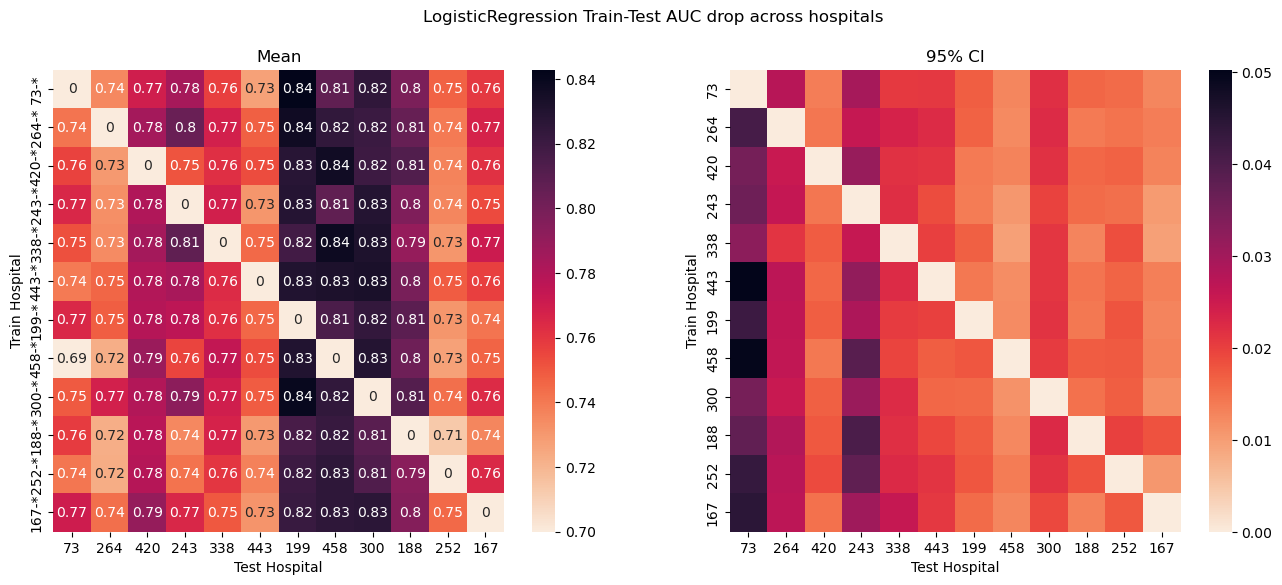

In [12]:
metric = 'AUC'
fig, axes = plt.subplots(figsize=(16, 6), nrows=1, ncols=2)
train_test_ids = [f"{h}-*" for h in hospital_ids]

plot_mat = avg_dict[metric] #+ np.diagonal(dist_shift_avg[metric])*np.eye(len(hospital_ids)) 
           
sns.heatmap(plot_mat, annot=True, cmap="rocket_r", ax=axes[0], 
            xticklabels=hospital_ids, 
           yticklabels=train_test_ids, 
           vmin=0.7)
axes[0].set_xlabel("Test Hospital")
axes[0].set_ylabel("Train Hospital")
axes[0].set_title("Mean")


CI = ci_dict[metric][1] - avg_dict[metric]
sns.heatmap(CI, fmt=".2e", annot_kws={'fontsize':7}, cmap="rocket_r", 
                      xticklabels=hospital_ids, 
           yticklabels=hospital_ids,)
axes[1].set_xlabel("Test Hospital")
axes[1].set_ylabel("Train Hospital")
axes[1].set_title("95% CI")

plt.suptitle(f"{model} Train-Test {metric} drop across hospitals")